Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from utils.dataset import SICKLE_Dataset
from utils import utae_utils, model_utils
from torch.utils import data
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Dataset

In [4]:
df = pd.read_csv("dataset/sickle_dataset_tabular.csv")

In [5]:
train_df = df[df.SPLIT == "train"].reset_index(drop=True)
val_df = df[df.SPLIT == "val"].reset_index(drop=True)
test_df = df[df.SPLIT == "test"].reset_index(drop=True)

In [6]:
# Configuration dictionary for dataset
dataset_config = {
    'data_dir': 'dataset/',
    'satellites': {
        "S2": {
            "bands": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'],
            "rgb_bands": [3, 2, 1],
            "mask_res": 10,
            "img_size": (32, 32),
        }
    },
    'ignore_index': -999,
    'transform': None,
    'actual_season': False,
    'phase': 'eval'  # Assuming phase could be 'train' or 'eval' based on your setup
}

In [7]:
dt_train = SICKLE_Dataset(df= train_df, **dataset_config)

In [8]:
print(dt_train[0][0])

{'S2': (array([[[[   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         ...,
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.],
         [   0.,    0.,    0., ...,    0.,    0.,    0.]],

        [[ 992.,  946.,  895., ...,    0.,    0.,    0.],
         [ 938.,  919.,  891., ...,  818.,  808.,  814.],
         [ 910.,  888.,  900., ...,  892.,  860.,  827.],
         ...,
         [1210., 1202., 1106., ...,  781.,  795.,  771.],
         [1052., 1070.,  940., ...,  692.,  747.,  816.],
         [ 963.,  977.,  958., ...,  689.,  767.,  919.]],

        [[1322., 1238., 1186., ...,    0.,    0.,    0.],
         [1192., 1130., 1118., ..., 1216., 1222., 1254.],
         [1180., 1124., 1108., ..., 1198., 1226., 1234.],
         ...,
         [1584., 1578., 1438., ..., 1290., 1194., 1160.],
         [1486., 1

In [9]:
dt_val = SICKLE_Dataset(df= val_df, **dataset_config)

In [10]:
np.set_printoptions(threshold=np.inf)

In [11]:
print(dt_train)

In [12]:
print(len(dt_train))
print(len(dt_val))

1937
227


In [13]:
#  WRITTEN RANDOM VALUES HERE TO SEE IF CODE IS WORKING
batch_size = 227
num_workers = 5

Dataloaders

In [14]:
collate_fn = lambda x: utae_utils.pad_collate(x, pad_value=0)
train_loader = data.DataLoader(
    dt_train,
    batch_size=1937,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
)
val_loader = data.DataLoader(
    dt_val,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
)

In [15]:
batch_data, masks = next(iter(train_loader))

/home/dlpl/code/SICKLE/utils/utae_utils.py:35: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/home/dlpl/code/SICKLE/utils/utae_utils.py:37: UserWarning: An output with one or more elements was resized since it had shape [1761337344], which does not match the required output shape [1937, 74, 12, 32, 32]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  return torch.stack(batch, 0, out=out)
/home/dlpl/code/SICKLE/utils/utae_utils.py:37: UserWarning: An output with one or 

In [16]:
val_batch_data, val_masks = next(iter(val_loader))

/home/dlpl/code/SICKLE/utils/utae_utils.py:35: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/home/dlpl/code/SICKLE/utils/utae_utils.py:37: UserWarning: An output with one or more elements was resized since it had shape [206413824], which does not match the required output shape [227, 74, 12, 32, 32]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  return torch.stack(batch, 0, out=out)
/home/dlpl/code/SICKLE/utils/utae_utils.py:37: UserWarning: An output with one or mo

In [17]:
print(len(val_masks['crop_yield']))

227


In [18]:
task= "crop_yield"

In [19]:
for sat in dataset_config['satellites'].keys():
        (samples, dates) = batch_data[sat]
        print(f"-----------{sat}------------")
        print("Samples Shape", samples.shape, "Masks Shape", masks["crop_type"].shape)
        print("dates", dates[0])
        print("Samples", torch.unique(samples[0]))
        print("Masks", torch.unique(masks[task]))

-----------S2------------
Samples Shape torch.Size([1937, 74, 12, 32, 32]) Masks Shape torch.Size([1937, 32, 32])
dates tensor([  3,  28,  38,  43,  58,  78,  83,  88,  93,  98, 103, 108, 113, 118,
        123, 128, 133, 138, 143, 148, 153, 158, 163, 168, 173, 178,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0])
Samples tensor([    0.,   171.,   185.,  ..., 16323., 16325., 16326.])
Masks tensor([-999.0000,   24.0000,   28.2759,   28.9286,   32.1429,   33.3333,
          37.2727,   37.3333,   37.5000,   38.6667,   40.0000,   40.4444,
          41.0256,   41.5385,   42.6316,   43.0769,   44.1379,   45.0000,
          45.5172,   45.7895,   46.1538,   47.0270,   47.5676,   48.0000,
          48.2759,   49.2308,   50.0000,   51.1111,   51.6667,   53.3333,
          54.3

In [30]:
for i in range(100):
    a = torch.unique(masks[task][i])
    print(a)

tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.0000,  148.3333], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.0000,  180.0000,  195.5556], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.0000,   87.6189,  111

In [67]:
print(batch_data)

{'S2': [tensor([[[[[2.9860e+03, 2.9860e+03, 2.9860e+03,  ..., 3.1110e+03,
            3.1110e+03, 3.1110e+03],
           [2.9860e+03, 2.9860e+03, 2.9860e+03,  ..., 3.1110e+03,
            3.1110e+03, 3.1110e+03],
           [2.9860e+03, 2.9860e+03, 2.9860e+03,  ..., 3.1110e+03,
            3.1110e+03, 3.1110e+03],
           ...,
           [3.1980e+03, 3.1980e+03, 3.1980e+03,  ..., 3.2110e+03,
            3.2110e+03, 3.2110e+03],
           [3.1980e+03, 3.1980e+03, 3.1980e+03,  ..., 3.2110e+03,
            3.2110e+03, 3.2110e+03],
           [3.1980e+03, 3.1980e+03, 3.1980e+03,  ..., 3.2110e+03,
            3.2110e+03, 3.2110e+03]],

          [[2.8020e+03, 2.7780e+03, 2.8080e+03,  ..., 2.9320e+03,
            2.9180e+03, 2.8900e+03],
           [2.7920e+03, 2.8020e+03, 2.8020e+03,  ..., 2.9440e+03,
            2.9180e+03, 2.9300e+03],
           [2.7920e+03, 2.8140e+03, 2.8000e+03,  ..., 2.9660e+03,
            2.9400e+03, 2.9000e+03],
           ...,
           [2.9660e+03, 2.9440e

In [68]:
print(masks['crop_yield'])

tensor([[[-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         ...,
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.]],

        [[-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         ...,
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.]],

        [[-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         ...,
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [

In [69]:
print("Original batch_data['S2'][0] shape:", batch_data['S2'][0].shape)  
print("Original masks['crop_yield'] shape:", masks['crop_yield'].shape)  

Original batch_data['S2'][0] shape: torch.Size([1937, 74, 12, 32, 32])
Original masks['crop_yield'] shape: torch.Size([1937, 32, 32])


In [70]:
print("Original batch_data['S2'][0] shape:", val_batch_data['S2'][0].shape)  
print("Original masks['crop_yield'] shape:", val_masks['crop_yield'].shape)  

Original batch_data['S2'][0] shape: torch.Size([227, 74, 12, 32, 32])
Original masks['crop_yield'] shape: torch.Size([227, 32, 32])


In [71]:
import torch

# Assuming 'batch_data' is your loaded batch data with shape [100, 74, 12, 32, 32]
# Indices for Red and NIR bands (assuming index starts at 0 and Band 4 is at index 3 and Band 8 is at index 7)
red_band_index = 3
nir_band_index = 7

# Extracting the Red and NIR bands
red = batch_data['S2'][0][:, :, red_band_index, :, :]  # shape [100, 74, 32, 32]
nir = batch_data['S2'][0][:, :, nir_band_index, :, :]  # shape [100, 74, 32, 32]

# Calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-10)  # Adding a small number to avoid division by zero

# Example: Flatten NDVI to use as features, you may choose to reshape or summarize differently based on your needs
ndvi_flat = ndvi.reshape(ndvi.shape[0], -1)  # Flattening each image in the batch

print("NDVI calculated with shape:", ndvi.shape)

NDVI calculated with shape: torch.Size([1937, 74, 32, 32])


In [72]:
# FOR VAL

# Extracting the Red and NIR bands
val_red = val_batch_data['S2'][0][:, :, red_band_index, :, :]  # shape [100, 74, 32, 32]
val_nir = val_batch_data['S2'][0][:, :, nir_band_index, :, :]  # shape [100, 74, 32, 32]

# Calculate NDVI
val_ndvi = (val_nir - val_red) / (val_nir + val_red + 1e-10)  # Adding a small number to avoid division by zero

# Example: Flatten NDVI to use as features, you may choose to reshape or summarize differently based on your needs
val_ndvi_flat = val_ndvi.reshape(val_ndvi.shape[0], -1)  # Flattening each image in the batch

print("NDVI calculated with shape:", val_ndvi.shape)

NDVI calculated with shape: torch.Size([227, 74, 32, 32])


In [73]:
print(ndvi_flat.shape)

torch.Size([1937, 75776])


In [74]:
# Temporal aggregation - using the mean as an example
ndvi_mean = torch.mean(ndvi, dim=1)  # Now shape [100, 32, 32], mean over temporal dimension

In [75]:
# Assuming ndvi_mean is correctly shaped as [100, 32, 32]
X_train = ndvi_mean.reshape(-1, 32*32)  # This now correctly reshapes to [100, 1024] as intended
y_train = masks['crop_yield'].reshape(-1)  # Flatten masks to [100 * 1024]

# Since each pixel across each image in the batch is now a sample:
X_train = X_train.reshape(-1, 1)  # Reshape X_train to [100*1024, 1] where each row is a pixel feature vector
y_train = y_train.flatten()  # Ensure y_train is a flat array [100*1024]

# Now X_train and y_train should be aligned:
print("X_train shape:", X_train.shape)  # Should be (102400, 1)
print("y_train shape:", y_train.shape)  # Should be (102400,)

# Filter out invalid data points where y_train is -999
valid_indices = y_train != -999
X_train = X_train[valid_indices]
y_train = y_train[valid_indices]

X_train shape: torch.Size([1983488, 1])
y_train shape: torch.Size([1983488])


In [76]:
# Proceed to train the RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [77]:
# Assuming val_ndvi and val_masks are available
# Temporal aggregation (mean NDVI over temporal dimension)
val_ndvi_mean = torch.mean(val_ndvi, dim=1)  # [batch_size, height, width]

# Reshape validation NDVI to match the training data's shape
X_val = val_ndvi_mean.reshape(-1, 32*32)  # Flatten to [batch_size, features]
y_val = val_masks['crop_yield'].reshape(-1)  # Flatten masks to [batch_size * height * width]
print(X_val.shape)
print(y_val.shape)


torch.Size([227, 1024])
torch.Size([232448])


In [78]:
print(len(y_val))

232448


In [79]:
# Reshape X_val to have one pixel per row, matching the y_val structure
X_val = X_val.reshape(-1, 1)  # This should result in [100*1024, 1], i.e., [102400, 1]
print("Reshaped X_val:", X_val.shape)
print("y_val shape:", y_val.shape)

# Proceed with filtering out invalid data points where y_val is -999
valid_indices_val = y_val != -999
X_val = X_val[valid_indices_val]
y_val = y_val[valid_indices_val]

Reshaped X_val: torch.Size([232448, 1])
y_val shape: torch.Size([232448])


In [80]:
print(X_val)

tensor([[0.3480],
        [0.3387],
        [0.3432],
        [0.3297],
        [0.3226],
        [0.3260],
        [0.3448],
        [0.3299],
        [0.3261],
        [0.3300],
        [0.3045],
        [0.3038],
        [0.3121],
        [0.3132],
        [0.3130],
        [0.3171],
        [0.3158],
        [0.3165],
        [0.3184],
        [0.3237],
        [0.3252],
        [0.3277],
        [0.3268],
        [0.3218],
        [0.3147],
        [0.3113],
        [0.3141],
        [0.3197],
        [0.3111],
        [0.3057],
        [0.3067],
        [0.3129],
        [0.3146],
        [0.3092],
        [0.3059],
        [0.3084],
        [0.3085],
        [0.3086],
        [0.3042],
        [0.3082],
        [0.3093],
        [0.3108],
        [0.3065],
        [0.3071],
        [0.3109],
        [0.3132],
        [0.3101],
        [0.3116],
        [0.3136],
        [0.3167],
        [0.3137],
        [0.3153],
        [0.1705],
        [0.1759],
        [0.1453],
        [0

Validation MSE: 8591.34994609298
Validation MAE: 57.373245169207244
Validation R2 Score: -2.4908301226532283


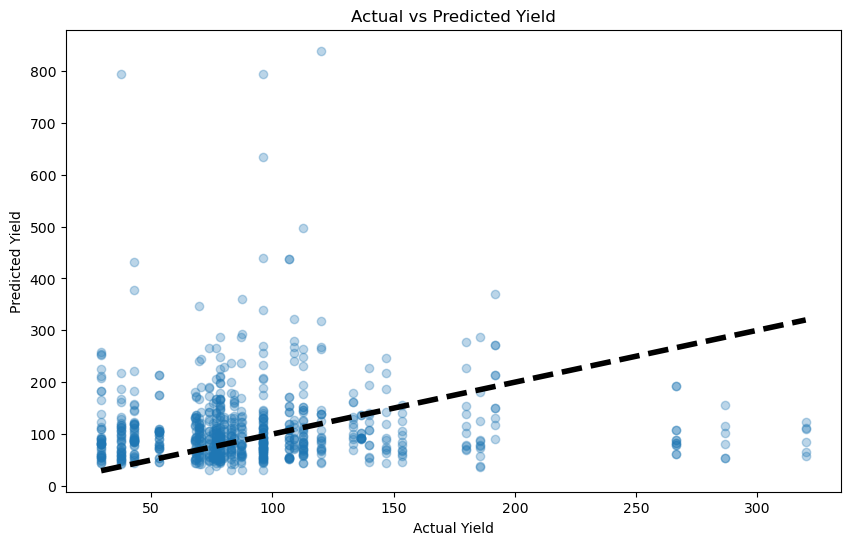

In [81]:

# Predict with the trained RandomForest model
y_pred = rf_model.predict(X_val)

# Evaluate the model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Validation MSE:", mse)
print("Validation MAE:", mae)
print("Validation R2 Score:", r2)

# Visualization (Optional but recommended for inspection)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Yield')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
plt.show()

Validation MAPE: 78.92059800973949
Validation MSE: 8591.34994609298
Validation MAE: 57.373245169207244
Validation R2 Score: -2.4908301226532283


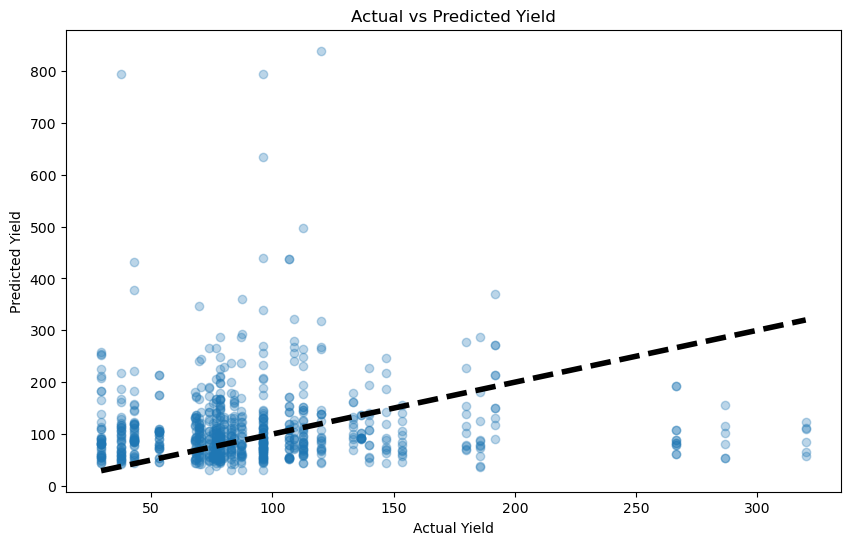

In [84]:
import numpy as np

def calculate_mape(y_true, y_pred):
    """ Calculate MAPE avoiding division by zero and convert to percentage """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0  # Ensure we don't divide by zero
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Predict with the trained RandomForest model
y_pred = rf_model.predict(X_val)

# Calculate MAPE
mape = calculate_mape(y_val, y_pred)
print("Validation MAPE:", mape)

# Evaluate the model performance using other metrics
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Validation MSE:", mse)
print("Validation MAE:", mae)
print("Validation R2 Score:", r2)

# Visualization (Optional but recommended for inspection)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Yield')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
plt.show()

Dataset Exploration

In [85]:
# import rasterio
# import numpy as np
# path = "dataset/masks/10m/2068.tif"

# np.set_printoptions(threshold=np.inf)
# with rasterio.open(path, 'r') as fp:
#     mask = fp.read()

# print(mask[0])